In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import shelve
import numba as nb

In [2]:
@nb.njit()
def frk4_step(y,u0,umid,u1,h,w,K,F,N):
    k1 = h * Fkuramoto_nb( y, u0,w,K,F,N)
    k2 = h * Fkuramoto_nb(y + 0.5 * k1, umid,w,K,F,N)
    k3 = h * Fkuramoto_nb( y + 0.5 * k2, umid,w,K,F,N)
    k4 = h * Fkuramoto_nb(y + k3, u1, w,K,F,N)
    y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    return ((y) % (2*math.pi))

@nb.njit()
def Fkuramoto_nb(x,ut,w,K,F,N):
    y = np.empty((x.shape[0]),dtype='float64')
    R1=0
    R2=0
    for i in nb.prange(x.shape[0]):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(x.shape[0]):
        y[i] = w[i] - K*R2*np.sin(x[i])/N + K*R1*np.cos(x[i])/N +  F* np.sin(ut[i]-x[i])
    return y

@nb.njit()
def whipeout(N, initlen, ut0,utmid,ut1, x0, h,w,p):
    uin, K,F= p[0],p[1], p[2]
    
    
    for j in nb.prange(initlen):
        U0 = ut0[:,j]
        Umid = utmid[:,j]
        U1 = ut1[:,j]
        
        x  = frk4_step(x0,uin*U0,uin*Umid,uin*U1,h,w,K,F,N)
        x0 = x
    return x

@nb.njit()
def kura_run(N,runlen, ut0, utmid,ut1, x0, h,w,p):
    uin, K,F = p[0],p[1], p[2]
    X = np.empty((N,runlen), dtype = 'float64')
    for j in nb.prange(runlen):
        U0 = ut0[:,j]
        Umid = utmid[:,j]
        U1 = ut1[:,j]
        
        x  = frk4_step(x0,uin*U0,uin*Umid,uin*U1,h,w,K,F,N)
        x0 = x
        X[:,j] = x
    return X

@nb.njit()
def nb_concatdotM0( x, y,M): 
    res = np.zeros(M,dtype = 'float64')
    for j in nb.prange(M):
        for i in nb.prange(x.shape[1]):
            if i==0:
                res[j]+=x[j,i]
            else:
                res[j]+=x[j,i]*y[i-1]
    return res

@nb.njit()
def NMSE(yeval,ydata):
    
    nmse = np.zeros(yeval.shape[0], dtype='float64')
    for i in nb.prange(yeval.shape[0]):
        for j in nb.prange(yeval.shape[1]):
            nmse[i] += (ydata[i,j]-yeval[i,j])**2
        nmse[i]=nmse[i]/numba_norm(ydata[i,:])**2
    return nmse

@nb.njit() 
def numba_norm(a):
    n = a.shape[0]
    norm = 0
    for i in range(n):
        norm += a[i] * a[i]
    return np.sqrt(norm)

@nb.njit()
def varRK4(t, state, dt, f, p, pvec,Wout,w,N,M):
    tmid = t + dt*0.5
    k1 = dt*fkura_closed(t,state,p,pvec,Wout,w,N,M) 
    k2 = dt*fkura_closed(t,state + 0.5 * k1,p,pvec,Wout,w,N,M)
    k3 = dt*fkura_closed(t,state + 0.5 * k2,p,pvec,Wout,w,N,M) 
    k4 = dt*fkura_closed(t + dt ,state + k3,p,pvec,Wout,w,N,M)
    y= (state + (1.0/6.0) * (k1 + 2*k2 + 2*k3 + k4))
    return ( y % (2*math.pi))
    
@nb.njit()
def fkura_closed(t,x,p,pvec,Wout,w,N,M):
    
    uin, K,F = p[0],p[1],p[2]
    one_hot = pvec
    
    y = np.empty(N,dtype='float64')
    R1=0
    R2=0
    
    Up0= nb_concatdotM0(Wout, concat_nb0(np.sin(x), np.sin(x)**2),M)
    
    for i in nb.prange(N):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(N):
        y[i] = w[i] - K*R2*np.sin(x[i])/N + K*R1*np.cos(x[i])/N +  F* np.sin(Up0[one_hot[i]]*uin-x[i])
       
    return y

@nb.njit()
def concat_nb0(x,y):
    res = np.empty( (x.shape[0]+y.shape[0]), dtype = 'float64')
    for i in nb.prange(x.shape[0]+y.shape[0]):
        if i < x.shape[0]:
            res[i] = x[i]
        else:
            res[i] = y[i- x.shape[0] ]
    return res 

@nb.njit()
def solve(N,M,x0, p,pvec, Wout,u0, w,dt,testlen=200):
    X = np.zeros((N,testlen+1), dtype = 'float64') 
    U_pred = np.zeros((M,testlen+1), dtype = 'float64')
    U_pred[:,0] = u0
    Up=u0
    X[:,0] = x0
    t=0
    for j in nb.prange(testlen):
        t=dt+t
        X[:,j+1] = varRK4(t, X[:,j], dt, fkura_closed, p, pvec,Wout,w,N,M)
    
        xstate = concat_nb0(np.sin(X[:,j+1]), np.sin(X[:,j+1])**2)
        Up= nb_concatdotM0(Wout, xstate,M)

        U_pred[:,j+1]= Up  

    return  U_pred[:,1:], X[:,1:]

In [3]:
with shelve.open('shelve/param.shelve', 'r') as shelf:
    p_dict = shelf['ks_equations']  
    
with shelve.open('data/data_sets.shelve', 'r') as shelf:
    data = shelf['ks_equations'] 

In [4]:
mdata = data[::2,::8]
M = mdata.shape[1]
data_scaled= mdata.T

uin,K,F= p_dict['uin'],p_dict['K'],p_dict['F']
N = p_dict['N']
w = p_dict['w']
h = p_dict['h']
p = np.array([uin, K,F])

one_hot_output = p_dict['one_hot']

ut0 =np.eye(M)[one_hot_output] @ data_scaled[:,::2]
utmid =np.eye(M)[one_hot_output] @ data_scaled[:,1:][:,::2]
ut1 =np.eye(M)[one_hot_output] @  data_scaled[:,2:][:,::2]

trainlen= p_dict['trainlen']
initlen =  p_dict['initlen']
testlen = p_dict['testlen']
reg= p_dict['reg']

In [5]:
x=whipeout(N,initlen, ut0,utmid,ut1, np.linspace(0,2*math.pi,N), h, w,p)
X0= kura_run(N,trainlen, ut0[:,initlen:],utmid[:,initlen:],ut1[:,initlen:], x,h,w,p)

X =  np.concatenate((np.expand_dims(np.ones(X0.shape[1]),axis=0),np.sin(X0),np.sin(X0)**2),axis=0)

Yt = data_scaled[:,::2][:,(initlen+1):(initlen+trainlen+1)].T

Wout = np.linalg.solve( np.dot(X,X.T) + reg*np.eye(2*N+1) , np.dot(X,Yt) ).T

nmse_train = NMSE(  np.dot(Wout,X), Yt.T).mean()

u0 = (Wout @ X[:,-1])
x0= X0[:,-1] 

ydata = data_scaled[:,::2][:, initlen+trainlen+1:initlen+trainlen+testlen+1]

U_pred, X_pred = solve(N,M, x0, p,one_hot_output, Wout,u0, w ,h,testlen=testlen)
nmse_test = NMSE(U_pred,ydata)

nmse_test_mean  = np.round(nmse_test.mean(),4)

In [6]:
nmse_test_mean

0.5556

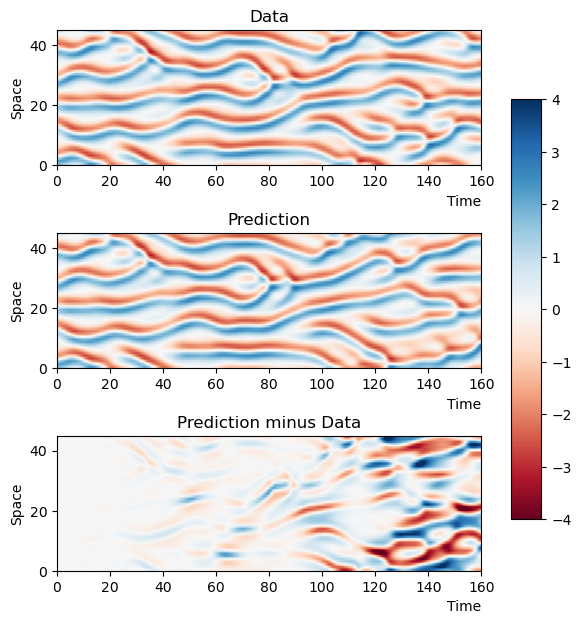

In [7]:

DT=0.05*4

fig, ax = plt.subplots(3, 1,figsize=(6,6))
#fig.suptitle(f'n{N}K{K}F{F}h{h}uin{p[0]}NMSE{np.round(nmse_test_mean,4)}')
fig.tight_layout() 
fig.subplots_adjust(hspace=0.5)
im = ax[1].imshow(U_pred,cmap="RdBu",
aspect="auto", extent=(0, U_pred.shape[1]*DT, 0, 45),        vmin=-4,
    vmax=4,
origin="lower")
ax[1].set_title('Prediction')
ax[1].set_xlabel('Time', loc='right')
ax[1].set_ylabel('Space')

ax[0].imshow(ydata,cmap="RdBu",
aspect="auto",  extent=(0, U_pred.shape[1]*DT, 0, 45),        vmin=-4,
    vmax=4,
origin="lower")
ax[0].set_title('Data')
ax[0].set_xlabel('Time', loc='right')
ax[0].set_ylabel('Space')


ax[2].imshow(U_pred-ydata,cmap="RdBu",
aspect="auto",  extent=(0, U_pred.shape[1]*DT, 0, 45),        vmin=-4,
    vmax=4,
origin="lower")
ax[2].set_title('Prediction minus Data')
ax[2].set_xlabel('Time', loc='right')
ax[2].set_ylabel('Space')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig(f'pictures_paper/sk.jpg',dpi=300,bbox_inches = 'tight')


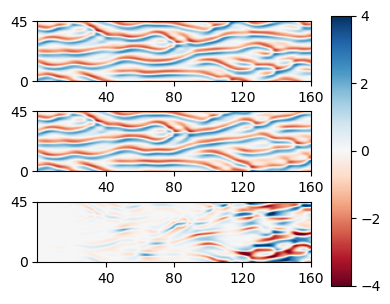

In [31]:

DT=0.05*4

fig, ax = plt.subplots(3, 1,figsize=(4,3))
#fig.suptitle(f'n{N}K{K}F{F}h{h}uin{p[0]}NMSE{np.round(nmse_test_mean,4)}')
fig.tight_layout() 
fig.subplots_adjust(hspace=0.5)
im = ax[1].imshow(U_pred,cmap="RdBu",
aspect="auto", extent=(0, U_pred.shape[1]*DT, 0, 45),        vmin=-4,
    vmax=4,
origin="lower")
ax[1].set_xticks([40,80,120,160])
ax[1].set_yticks([0,45])
#ax[1].set_title('Prediction')
#ax[1].set_xlabel('Time', loc='right')
#ax[1].set_ylabel('Space')

ax[0].imshow(ydata,cmap="RdBu",
aspect="auto",  extent=(0, U_pred.shape[1]*DT, 0, 45),        vmin=-4,
    vmax=4,
origin="lower")
ax[0].set_xticks([40,80,120,160])
ax[0].set_yticks([0,45])
#ax[0].set_title('Data')
#ax[0].set_xlabel('Time', loc='right')
#ax[0].set_ylabel('Space')


ax[2].imshow(U_pred-ydata,cmap="RdBu",
aspect="auto",  extent=(0, U_pred.shape[1]*DT, 0, 45),        vmin=-4,
    vmax=4,
origin="lower")
ax[2].set_xticks([40,80,120,160])
ax[2].set_yticks([0,45])
#ax[2].set_title('Prediction minus Data')
#ax[2].set_xlabel('Time', loc='right')
#ax[2].set_ylabel('Space')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.05, 0.05, 0.9])
fig.colorbar(im, cax=cbar_ax, ticks=[-4,-2,0,2,4])
plt.savefig(f'pictures_paper/sk.jpg',dpi=300,bbox_inches = 'tight')

In [17]:
# random initial conditions
nmse_list = []
for _ in range(10):
    x=whipeout(N,initlen, ut0,utmid,ut1,  (np.linspace(0,2*math.pi,N)+np.random.rand(N)*2*np.pi) % (2*np.pi), h, w,p)
    X0= kura_run(N,trainlen, ut0[:,initlen:],utmid[:,initlen:],ut1[:,initlen:], x,h,w,p)

    X =  np.concatenate((np.expand_dims(np.ones(X0.shape[1]),axis=0),np.sin(X0),np.sin(X0)**2),axis=0)

    Yt = data_scaled[:,::2][:,(initlen+1):(initlen+trainlen+1)].T

    Wout = np.linalg.solve( np.dot(X,X.T) + reg*np.eye(2*N+1) , np.dot(X,Yt) ).T

    nmse_train = NMSE(  np.dot(Wout,X), Yt.T).mean()

    u0 = (Wout @ X[:,-1])
    x0= X0[:,-1] 

    ydata = data_scaled[:,::2][:, initlen+trainlen+1:initlen+trainlen+testlen+1]

    U_pred, X_pred = solve(N,M, x0, p,one_hot_output, Wout,u0, w ,h,testlen=testlen)
    nmse_test = NMSE(U_pred,ydata)

    nmse_test_mean  = np.round(nmse_test.mean(),4)
    nmse_list.append(nmse_test_mean)
print(np.mean(nmse_list),np.std(nmse_list))

0.5556 0.0
